In [26]:
# !pip install psycopg2-binary==2.9.1
# !pip install pandas==1.3.4
# !pip install SQLAlchemy==1.4.25
# !pip install typing-extensions==3.10.0.0
# !pip install mlflow==1.20.2
# !pip install scikit-learn==0.24.2
# !pip install numpy==1.20.2
# !pip install seaborn==0.11.2
# !pip install matplotlib==3.4.3
# !pip install boto3==1.19.12
# !pip install xgboost==1.5.0
# !pip install lightgbm==3.3.1
# !pip install catboost==1.0.3
# !pip install optuna==2.10.0
# !pip install category_encoders
# !pip install -r requirements.txt
# !pip install -i https://test.pypi.org/simple/ kaml==1.0
# !pip install pyxlsb
# !pip install lime
    
# # !pip install "pyarrow>=4.0.0" --prefer-binary
# # !pip uninstall pyspark -y
# # !pip install mlflow==1.20.2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import base64
import os
# import mlflow
from transformations import *

from kaml.client import *
from kaml.classification import *
import json
import base64

import joblib

## Parameters

In [29]:
base_location = "kfs_private/"

In [171]:
pd.set_option('display.max_columns',120)


def decode_py(message):
    base64_bytes = message.encode('ascii')
    message_bytes = base64.b64decode(base64_bytes)
    return message_bytes.decode('ascii')

def encode_py(message):
    message_bytes = message.encode('ascii')
    base64_bytes = base64.b64encode(message_bytes)
    return base64_bytes.decode('ascii')

with open(base_location+'passcodes.json','r') as f:
    passcodes = json.load(f)
    
# set environment variable
os.environ['MLFLOW_S3_ENDPOINT_URL'] = decode_py(
    passcodes['MLFLOW_S3_ENDPOINT_URL']
)

os.environ['AWS_ACCESS_KEY_ID'] = decode_py(
    passcodes['AWS_ACCESS_KEY_ID']
)

os.environ['AWS_SECRET_ACCESS_KEY'] = decode_py(
    passcodes['AWS_SECRET_ACCESS_KEY']
)

os.environ['MLFLOW_BASE_URL'] = decode_py(
    passcodes['MLFLOW_BASE_URL']
)

mlflow.set_tracking_uri(os.environ['MLFLOW_BASE_URL'])
client = mlflow.tracking.MlflowClient(os.environ['MLFLOW_BASE_URL'])

MINIO_HOST='http://mlflow-minio-service.mlflow.svc.cluster.local:9000'
MINIO_ACCESS_KEY="minio"
MINIO_SECRET_KEY="BS6PpUKnW^Bkc@$l$QAsY$p#l"
MINIO_MODEL_BUCKET="models"

exp_name = "tpl_flg_no_hyrrach"

In [167]:
# #create bucket in minio
# from minio import *
# def get_minio():
#     return Minio(MINIO_HOST.split("http://")[1],access_key=MINIO_ACCESS_KEY,secret_key=MINIO_SECRET_KEY,secure=False)

# minio_client = get_minio()

# minio_client.make_bucket(MINIO_MODEL_BUCKET)

# minio_client.list_buckets()

[Bucket('models')]

### Read Parent Complaint file

In [27]:
# parent_comp_df =  pd.read_excel("NPC Dump of 2 Years.xlsb")
# parent_comp_df.columns = rename_columns(parent_comp_df,prefix="parent_")
# parent_comp_df.rename(columns = {'parent_unnamed:_5':'parent_msp_circuit_description',
#                                 'parent_unnamed:_68':'parent_fsp_circuit_description'},inplace=True)

In [30]:
# columns_at_reg = ['parent_complaint_number','parent_business_partner','parent_reg_date', 'parent_reg__time', 'parent_msp_circuit',
#        'parent_msp_circuit_description', 'parent_final_obs__code_group','parent_final_obs__code', 'parent_mru', 'parent_industry',
#        'parent_industry_system', 'parent_affected_bp','parent_restoration_duration', 'parent_mode', 'parent_regi__group',
#        'parent_regi__code', 'parent_rate_category', 'parent_bp_classification','parent_account_class', 'parent_location', 
#        'parent_sub_station','parent_area', 'parent_responsible_zone', 'parent_responsible_dept',
#        'parent_zone', 'parent_fsp_circuit', 'parent_fsp_circuit_description','parent_affected_func__location']
# parent_comp_df = parent_comp_df[columns_at_reg]

### Read Child Complaint file

In [31]:
child_comp_df =  pd.read_excel("Child Complaint Details.xlsb")
child_comp_df.columns = rename_columns(child_comp_df,prefix="child_")

### Read Hierarchy Data

In [32]:
hierarchy_df = pd.read_csv(base_location+"bp_hierarchy_file.csv")
#hierarchy_df.columns = rename_columns(hierarchy_df,prefix="hrcrhy_")
hierarchy_df.columns

Index(['hrcrhy_zone', 'hrcrhy_portion', 'hrcrhy_business_partner',
       'hrcrhy_11kv_oh_feeder_cb', 'hrcrhy_11kv_ug_feeder_cb',
       'hrcrhy_22_kv_feeder', 'hrcrhy_22_kv_sub_feeder',
       'hrcrhy_ht_customer_ss', 'hrcrhy_dist__sub_station',
       'hrcrhy_dist_transformer', 'hrcrhy_fsp', 'hrcrhy_fsp_circuit',
       'hrcrhy_fsp_sub_circuit', 'hrcrhy_dfsp', 'hrcrhy_dfsp_circuit',
       'hrcrhy_dfsp_sub_circuit', 'hrcrhy_msp', 'hrcrhy_msp_circuit',
       'hrcrhy_otdp', 'hrcrhy_ottp', 'hrcrhy_lt_sw_fuse_unit',
       'hrcrhy_delivery_point', 'hrcrhy_bbc_ahd_', 'hrcrhy_dist__box',
       'hrcrhy_device_location', 'hrcrhy_count'],
      dtype='object')

### Merge Dataframes

In [33]:
# parent_child_df = parent_comp_df.merge(child_comp_df, left_on=['parent_complaint_number'],right_on=['child_parent_complaint'],how='inner')
# parent_child_df.shape

(72933, 171)

In [34]:
# parent_child_hrcrhy_df = parent_child_df.merge(hierarchy_df,left_on='child_partner_no',right_on='hrcrhy_business_partner',how='inner')
# parent_child_hrcrhy_df.shape

(68371, 197)

In [65]:
# parent_child_hrcrhy_df.to_csv(base_location+"parent_child_hrcrhy_df.csv",index=False,header=True)

parent_child_hrcrhy_df = pd.read_csv(base_location+"parent_child_hrcrhy_df.csv")
parent_child_hrcrhy_df.shape

(68371, 197)

In [66]:
parent_child_hrcrhy_df.columns

Index(['parent_complaint_number', 'parent_business_partner', 'parent_reg_date',
       'parent_reg__time', 'parent_msp_circuit',
       'parent_msp_circuit_description', 'parent_final_obs__code_group',
       'parent_final_obs__code', 'parent_mru', 'parent_industry',
       ...
       'hrcrhy_msp', 'hrcrhy_msp_circuit', 'hrcrhy_otdp', 'hrcrhy_ottp',
       'hrcrhy_lt_sw_fuse_unit', 'hrcrhy_delivery_point', 'hrcrhy_bbc_ahd_',
       'hrcrhy_dist__box', 'hrcrhy_device_location', 'hrcrhy_count'],
      dtype='object', length=197)

### Feature Set Label: New dependent variable: FLG(Functional Location Group)

In [67]:
parent_child_hrcrhy_df['flg'] = create_label(parent_child_hrcrhy_df, hierarchy_df)

In [68]:
parent_child_hrcrhy_df['flg'].unique()

array(['bbc_ahd_', 'not_in_hierarchy', 'dfsp_circuit', 'delivery_point',
       'msp_circuit', 'fsp_circuit', 'msp', 'dist_transformer',
       'lt_sw_fuse_unit', 'fsp', 'dfsp', 'ottp', 'dist__box',
       'fsp_sub_circuit', 'dfsp_sub_circuit', 'dist__sub_station',
       'device_location'], dtype=object)

#### Removing those rows whose affected functional location is not in any hirearchical FLG

In [69]:
parent_child_hrcrhy_df=parent_child_hrcrhy_df[parent_child_hrcrhy_df['flg']!='not_in_hierarchy']

In [70]:
parent_child_hrcrhy_df.shape 

(51176, 198)

## Filling Missing Values

In [71]:
parent_child_hrcrhy_df['parent_reg__time'] = fill_parent_reg__time(parent_child_hrcrhy_df)
parent_child_hrcrhy_df['parent_rate_category'] = fill_parent_rate_category(parent_child_hrcrhy_df)

parent_child_hrcrhy_df['parent_area'] = fill_parent_area(parent_child_hrcrhy_df[['parent_area']])
parent_child_hrcrhy_df['parent_mru'] = fill_parent_mru(parent_child_hrcrhy_df[['parent_mru']])

parent_child_hrcrhy_df['child_mru'] = fill_child_mru(parent_child_hrcrhy_df[['child_mru']])
parent_child_hrcrhy_df['child_location'] = fill_child_location(parent_child_hrcrhy_df[['child_location']])

## Format Data

In [72]:
parent_child_hrcrhy_df['parent_reg_date_time'] = format_parent_reg_date(parent_child_hrcrhy_df)
parent_child_hrcrhy_df['child_reg_date_time'] = format_child_reg_date(parent_child_hrcrhy_df)

In [73]:
# parent_child_hrcrhy_df = parent_child_hrcrhy_df[pd.to_datetime(parent_child_hrcrhy_df['parent_reg_date_time']) < pd.to_datetime('2021-07-01')]

## Feature Creation

**Feature 1: No of times the AFL is affected in past**

In [74]:
#parent_child_hrcrhy_df['no_of_times_asset_affected'] = no_of_times_asset_affected(parent_child_hrcrhy_df)

**Feature 2: When was the last time the asset was affected**

In [75]:
#parent_child_hrcrhy_df['days_when_asset_last_affected'] = days_when_asset_last_affected(parent_child_hrcrhy_df)

**Feature 3: Number of times hierarchy asset affected in past**

In [76]:
hierarchy_cols = ['hrcrhy_11kv_oh_feeder_cb','hrcrhy_11kv_ug_feeder_cb','hrcrhy_22_kv_feeder','hrcrhy_22_kv_sub_feeder','hrcrhy_ht_customer_ss',
                  'hrcrhy_dist__sub_station','hrcrhy_dist_transformer','hrcrhy_fsp','hrcrhy_fsp_circuit','hrcrhy_fsp_sub_circuit','hrcrhy_dfsp',
                  'hrcrhy_dfsp_circuit','hrcrhy_dfsp_sub_circuit','hrcrhy_msp','hrcrhy_msp_circuit','hrcrhy_otdp','hrcrhy_ottp','hrcrhy_lt_sw_fuse_unit',
                  'hrcrhy_delivery_point','hrcrhy_bbc_ahd_','hrcrhy_dist__box','hrcrhy_device_location']

In [77]:
for col in hierarchy_cols:
    parent_child_hrcrhy_df = hierarchy_asset_affected(parent_child_hrcrhy_df,col)

**Feature 4: Number of days before a particular asset was affected**

In [78]:
for col in hierarchy_cols:
    parent_child_hrcrhy_df = noof_days_before_asset_affected(parent_child_hrcrhy_df,col)

**Feature 5: whether customer is HT customer or not**

In [79]:
parent_child_hrcrhy_df['is_parent_ht_customer'] = is_parent_ht_customer(parent_child_hrcrhy_df)

**Feature 6: Average of affected BP in past for business partner**

In [80]:
#parent_child_hrcrhy_df['average_affected_bp'] = average_affected_bp(parent_child_hrcrhy_df)

**Feature 7: Median of affected BP in past for business partner**

In [81]:
#parent_child_hrcrhy_df['median_affected_bp_past'] = median_affected_bp_past(parent_child_hrcrhy_df)

**Feature 8: Number of complaints in the past for business partner**

In [82]:
parent_child_hrcrhy_df['no_of_complaints_for_bp_past'] = no_of_complaints_for_bp_past(parent_child_hrcrhy_df)

**Feature 9: Number of times complaint raised for asset in the past**

In [83]:
for col in hierarchy_cols:
    parent_child_hrcrhy_df[col+'_no_of_times_comlpt_raised_for_asset'] = no_of_times_comlpt_raised_for_asset(parent_child_hrcrhy_df,col)

**Feature 10: Date Time features**

In [84]:
parent_child_hrcrhy_df = date_time_features(parent_child_hrcrhy_df,'child_reg_date_time')
parent_child_hrcrhy_df = date_time_features(parent_child_hrcrhy_df,"parent_reg_date_time")

**Feature 11: Time difference between parent and child complaint**

In [85]:
parent_child_hrcrhy_df['time_diff_btwn_child_parent_cmplt_mins'] = time_diff_btwn_child_parent_cmplt(parent_child_hrcrhy_df)

**Feature 12: Number of past child complaints**

In [86]:
parent_child_hrcrhy_df['no_of_past_child_cmplt'] = no_of_past_child_cmplt(parent_child_hrcrhy_df)

**Feature 13: Is Child a VIP customer**

In [87]:
parent_child_hrcrhy_df['child_vip_flag']=child_vip_flag(parent_child_hrcrhy_df[['child_vip_flag']])

**Feature 14: Common lower heirarchy connection between parent and child**

In [88]:
hierarchy_list = ['hrcrhy_11kv_oh_feeder_cb', 'hrcrhy_11kv_ug_feeder_cb','hrcrhy_22_kv_feeder', 'hrcrhy_22_kv_sub_feeder',
       'hrcrhy_ht_customer_ss', 'hrcrhy_dist__sub_station','hrcrhy_dist_transformer', 'hrcrhy_fsp', 'hrcrhy_fsp_circuit',
       'hrcrhy_fsp_sub_circuit', 'hrcrhy_dfsp', 'hrcrhy_dfsp_circuit','hrcrhy_dfsp_sub_circuit', 'hrcrhy_msp', 'hrcrhy_msp_circuit',
       'hrcrhy_otdp', 'hrcrhy_ottp', 'hrcrhy_lt_sw_fuse_unit','hrcrhy_delivery_point', 'hrcrhy_bbc_ahd_', 'hrcrhy_dist__box','hrcrhy_device_location']
hierarchy_list.reverse()
def common_hrcrhy_level_of_child_parent(df):
    return list(map(lambda x: x, filter(lambda y: str(df[y+"_parent"]) == str(df[y+"_child"]),hierarchy_list)))[0]
    #hierarchy_temp_df = hierarchy_df[hierarchy_df['hrcrhy_business_partner']==df['child_partner_no']]
#     if not hierarchy_temp_df.empty:
#         return list(map(lambda x: x, filter(lambda y: str(df[y+"_parent"]) == df[y+"_child"].values[0],hierarchy_list)))[0]
#     else:
#         return np.NaN
#     for i in hierarchy_list:
#         if hierarchy_temp_df[i].empty:
#             return np.NaN
#         if str(df[i]) == hierarchy_temp_df[i].values[0]:
#             return i
#     return np.NaN

# temp_child_hrrcy = cmplts_hrchy_chld_df.merge(hierarchy_df,left_on='child_partner_no',right_on='hrcrhy_business_partner',suffixes=('_parent','_child'))
# temp_child_hrrcy.apply(common_hrcrhy_level_of_child_parent,axis=1).unique()

### Create Feature Meta Dictnory 

In [89]:
for col in hierarchy_cols:
    feature_creation_dict(parent_child_hrcrhy_df, col,col+"_noof_times_affected_in_past")

In [90]:
for col in hierarchy_cols:
    feature_creation_dict(parent_child_hrcrhy_df, col,col+"_noof_days_before_affected_in_past")

In [91]:
feature_creation_dict(parent_child_hrcrhy_df, 'child_partner_no',"no_of_complaints_for_bp_past")
#feature_creation_dict(parent_child_hrcrhy_df, 'parent_business_partner',"average_affected_bp")
#feature_creation_dict(parent_child_hrcrhy_df, 'parent_business_partner',"median_affected_bp_past")

In [92]:
for col in hierarchy_cols:
    feature_creation_dict(parent_child_hrcrhy_df, col,col+"_no_of_times_comlpt_raised_for_asset")

In [93]:
#joblib.dump(feature_meta_dict,base_location+"feature_meta_dict.joblib")

In [94]:
#feature_meta_dict =  joblib.load(base_location+"feature_meta_dict.joblib")

## Split Train, Test and Validation Data

In [95]:
## train_data = complaints_hierarchy_df[complaints_hierarchy_df['reg_date_time'] < pd.to_datetime('2021-07-01')]
## validation_data = complaints_hierarchy_df[(complaints_hierarchy_df['reg_date_time'] >= pd.to_datetime('2021-07-01')) & (complaints_hierarchy_df['reg_date_time'] < pd.to_datetime('2021-10-01'))]
## test_data = complaints_hierarchy_df[complaints_hierarchy_df['reg_date_time'] >= pd.to_datetime('2021-10-01')]

### Taking only 1st year data for training where number of child complaints > cmplnt_fmly_crtcl_mass

In [127]:
from sklearn.model_selection import train_test_split

train_val_data_all_cmplt = parent_child_hrcrhy_df[pd.to_datetime(parent_child_hrcrhy_df['parent_reg_date_time']) < pd.to_datetime('2021-07-01')]
test_data = parent_child_hrcrhy_df[pd.to_datetime(parent_child_hrcrhy_df['parent_reg_date_time']) >= pd.to_datetime('2021-07-01')]



In [128]:
cmplnt_fmly_crtcl_mass =2

In [129]:
#train_val_data = train_val_data[train_val_data.groupby('complaint_number').size()>cmplnt_fmly_crtcl_mass]

train_val_data = train_val_data_all_cmplt[train_val_data_all_cmplt.groupby(['parent_complaint_number'])['child_partner_no'].transform('count')>cmplnt_fmly_crtcl_mass]

In [130]:
train_data = train_val_data.groupby(['parent_complaint_number']).apply(lambda x: x.head(cmplnt_fmly_crtcl_mass)).reset_index(drop=True)

In [131]:
val_data = train_val_data.groupby(['parent_complaint_number']).apply(lambda x: x.iloc[cmplnt_fmly_crtcl_mass:,:]).reset_index(drop=True)

In [132]:
#from sklearn.model_selection import train_test_split
#train_val_data, test_data = train_test_split(cmplts_hrchy_chld_df,test_size=0.2,random_state=42)
#train_data, val_data = train_test_split(train_val_data,test_size=0.2,random_state=42)

In [133]:
print("Train Data : ", train_data.shape)
print("Validation Data : ", val_data.shape)
print("Test Data : ", test_data.shape)

Train Data :  (14616, 288)
Validation Data :  (7409, 288)
Test Data :  (10335, 288)


In [134]:
train_data['flg'].value_counts()

fsp_circuit          6466
msp_circuit          2036
delivery_point       1880
msp                  1756
dist_transformer      578
ottp                  524
fsp_sub_circuit       318
dfsp_circuit          258
fsp                   248
lt_sw_fuse_unit       194
bbc_ahd_              138
dist__box              98
dfsp_sub_circuit       72
dfsp                   36
dist__sub_station      12
device_location         2
Name: flg, dtype: int64

In [135]:
# l = train_data.columns[~train_data.columns.str.contains("hrcrhy_")]
# train_data[train_data['flg']=='delivery_point'][l].head()

## Drop Un-used features

In [136]:
child_cmplt_feat = ['affected_fl','affected_fl_count','allocation_date','allocation_time','allocation_duration',"name",'portion','regio_group',
 'attending_date','attending_time','attending_duration','created_by','diverted_dept','diverted_zone','faultman','faultman_id','object_id',
 'responsible_dept','status','system_condition','technician_remark','temp_date','temp_time','perm_date','responsible_zone','registration_time',
 'perm_time','temp_duration','perm_duration','observation_codegroup','observation_code','final_observation_codegroup_mains_','registration_date',
 'final_observation_code_mains_','power_restoration','mobile_no','sub_station','sub_station_name','feeder','address','creator_zone',
 'feeder_name','notification_no_yz_','planner_group','work_center','note1','note2','gross__duration','compliance_duration','description',
 'restoration_duration__min_','atteding_dur_from_allocation','within_internal_benchmark','internal_benchmark_def','npc_compliance',
 'neg_ind','final_observation','final_observation_code','complaint_group','rnpc_complaint','solved_by_rnpc','damage_memo_amt',
 'old_categ_1','old_categ_2','power_on_site','dtc_code','dtc_name','delivery_point','del_name','meter_no','service_status','repeat_call',
 'rnpc_visit_id','rnpc_visit_name','rate_cateogry','sanction_load','connected_load','bill_class','phase','mf','attended_user_id',
 'attended_user_name','mobile_no_1','mobile_no_2','notification_no_y9_','pending_in_minute','hv_notification','compliance_st_date',
 'compliance_st_time','compliance_end_date','compliance_end_time','diverted_date','diverted_time','reading_seq_no','legacy_seq_no',
 'direction','old_info','theft_ind','master_mobile_no_1','master_mobile_no_2','master_mobile_no_3','master_mobile_no_4','first_allocation_date',
 'first_allocation_time','actual_completion_date','actual_completion_time','creator_dept','npc_compliance_reason',
 'npc_compliance_reason_1','entered_attending_date','entered_attending_time','complainer_name','changed_by','changed_from',
 'act_comp_st_date','act_comp_st_time','act_comp_en_date','act_comp_en_time','old_tech_remark','amp_rating',
 'cause_code_group','cause_code','damage_code_group','damage_code','object_code_group','object_code','ckt_phase',
 'same_circuit_npc','last_reading','last_reading_date','manufacturer_serial_no','allocated_user_id','allocated_user_name','service_category']

In [137]:
child_cmplt_feat = ["child_"+x for x in child_cmplt_feat]

In [138]:
drop_columns = ['parent_reg__time','parent_industry','parent_industry_system','parent_reg_date','parent_reg_date_time','child_reg_date_time',
                'parent_affected_bp','parent_restoration_duration','parent_final_obs__code','parent_msp_circuit_description',
                'parent_affected_func__location','hrcrhy_count', 'parent_final_obs__code_group',
               'parent_fsp_circuit_description','parent_mode','parent_responsible_zone','parent_responsible_dept',
               'parent_area','parent_location','parent_sub_station','parent_mru','parent_rate_category',
                'parent_msp_circuit','parent_zone','hrcrhy_count','parent_fsp_circuit','parent_regi__group']+child_cmplt_feat ##'days_when_asset_last_affected','no_of_times_asset_affected'

In [139]:
train_data.drop(drop_columns,axis=1,inplace=True)
val_data.drop(drop_columns,axis=1,inplace=True)
test_data.drop(drop_columns,axis=1,inplace=True)

## Label Encode

In [145]:
label_encode_list = ['parent_account_class','parent_regi__code','parent_bp_classification','child_mru','child_area',
                     'child_location','child_mode','child_category_1', 'child_category_2']

# 'parent_msp_circuit','parent_location','parent_mru','parent_rate_category','parent_area',
# 'parent_sub_station', 'parent_zone','parent_fsp_circuit','parent_regi__group'
#'child_portion','child_regio_group'

In [141]:
hrcrhy_encode_list = ['hrcrhy_zone', 'hrcrhy_portion', 'hrcrhy_business_partner',
       'hrcrhy_11kv_oh_feeder_cb', 'hrcrhy_11kv_ug_feeder_cb',
       'hrcrhy_22_kv_feeder', 'hrcrhy_22_kv_sub_feeder',
       'hrcrhy_ht_customer_ss', 'hrcrhy_dist__sub_station',
       'hrcrhy_dist_transformer', 'hrcrhy_fsp', 'hrcrhy_fsp_circuit',
       'hrcrhy_fsp_sub_circuit', 'hrcrhy_dfsp', 'hrcrhy_dfsp_circuit',
       'hrcrhy_dfsp_sub_circuit', 'hrcrhy_msp', 'hrcrhy_msp_circuit',
       'hrcrhy_otdp', 'hrcrhy_ottp', 'hrcrhy_lt_sw_fuse_unit',
       'hrcrhy_delivery_point', 'hrcrhy_bbc_ahd_', 'hrcrhy_dist__box',
       'hrcrhy_device_location']

In [142]:
def label_encoding_fit(df, label_encode_list,file_name):
    label_encode = ce.OrdinalEncoder(cols=label_encode_list)
    label_encode.fit(df)
    joblib.dump(label_encode,file_name)
    
def label_encoding_transfrom(df,file_name):
    label_encode = joblib.load(file_name)
    return label_encode.transform(df)

In [143]:
loc = base_location+"hrcrhy_label_encode.joblib"
label_encoding_fit(hierarchy_df[hrcrhy_encode_list],hrcrhy_encode_list,loc)
train_data[hrcrhy_encode_list] = label_encoding_transfrom(train_data[hrcrhy_encode_list],loc)
val_data[hrcrhy_encode_list] = label_encoding_transfrom(val_data[hrcrhy_encode_list],loc)
test_data[hrcrhy_encode_list] = label_encoding_transfrom(test_data[hrcrhy_encode_list],loc)

In [146]:
loca = base_location+"label_encode.joblib"
label_encoding_fit(train_data[label_encode_list],label_encode_list,loca)
train_data[label_encode_list] = label_encoding_transfrom(train_data[label_encode_list],loca)
val_data[label_encode_list] = label_encoding_transfrom(val_data[label_encode_list],loca)
test_data[label_encode_list] = label_encoding_transfrom(test_data[label_encode_list],loca)

#### LabelEncode

In [147]:
train_data['flg'] = label_mapping(train_data[['flg']])
val_data['flg'] = label_mapping(val_data[['flg']])
test_data['flg'] = label_mapping(test_data[['flg']])

## Feature Selection

### Remove hierarchy features

In [148]:
hierarchy_list = ['hrcrhy_11kv_oh_feeder_cb', 'hrcrhy_11kv_ug_feeder_cb','hrcrhy_22_kv_feeder', 'hrcrhy_22_kv_sub_feeder',
       'hrcrhy_ht_customer_ss', 'hrcrhy_dist__sub_station','hrcrhy_dist_transformer', 'hrcrhy_fsp', 'hrcrhy_fsp_circuit',
       'hrcrhy_fsp_sub_circuit', 'hrcrhy_dfsp', 'hrcrhy_dfsp_circuit','hrcrhy_dfsp_sub_circuit', 'hrcrhy_msp', 'hrcrhy_msp_circuit',
       'hrcrhy_otdp', 'hrcrhy_ottp', 'hrcrhy_lt_sw_fuse_unit','hrcrhy_delivery_point', 'hrcrhy_bbc_ahd_', 'hrcrhy_dist__box','hrcrhy_device_location']

In [149]:
id_columns = ["parent_complaint_number","parent_business_partner",'child_partner_no','child_parent_complaint','hrcrhy_business_partner']
use_cols = list(set(train_data.columns) - set(id_columns))# - set(hierarchy_list))

### Univarient Features selection

In [150]:
sel_cols_uni = univarient_selection(train_data[use_cols])

### Correlation Features selection

In [151]:
sel_cols_corr = correlation_feature_elemination(train_data[sel_cols_uni],corr_factor=0.7)

In [152]:
label ='flg'

In [153]:
X_train = train_data[sel_cols_corr].drop(label,axis=1)
y_train = train_data[label]
X_val =  val_data[sel_cols_corr].drop(label,axis=1)
y_val =  val_data[label]
 

## Mutual Info feature selection

In [154]:
top_features_mu_info = mutual_info_score(X_train,y_train)

In [155]:
top_features_mu_info

['child_mru',
 'hrcrhy_11kv_ug_feeder_cb',
 'child_area',
 'hrcrhy_portion',
 'hrcrhy_fsp_circuit_noof_days_before_affected_in_past',
 'child_location',
 'hrcrhy_dfsp',
 'time_diff_btwn_child_parent_cmplt_mins',
 'hrcrhy_ottp',
 'hrcrhy_dfsp_circuit_noof_days_before_affected_in_past',
 'hrcrhy_lt_sw_fuse_unit',
 'hrcrhy_bbc_ahd_',
 'hrcrhy_dfsp_sub_circuit_no_of_times_comlpt_raised_for_asset',
 'hrcrhy_dfsp_noof_days_before_affected_in_past',
 'hrcrhy_fsp_circuit_noof_times_affected_in_past',
 'hrcrhy_msp_circuit_noof_days_before_affected_in_past',
 'hrcrhy_ottp_no_of_times_comlpt_raised_for_asset',
 'hrcrhy_dfsp_sub_circuit_noof_days_before_affected_in_past',
 'hrcrhy_dist_transformer_noof_days_before_affected_in_past',
 'hrcrhy_msp_no_of_times_comlpt_raised_for_asset',
 'hrcrhy_ottp_noof_days_before_affected_in_past']

## Recursive Feature Engineering

In [156]:
top_features_rfe = recursive_feature_engineering(X_train, y_train)

In [157]:
top = top_features_rfe
top

['hrcrhy_fsp_no_of_times_comlpt_raised_for_asset',
 'hrcrhy_portion',
 'child_mru',
 'hrcrhy_lt_sw_fuse_unit',
 'hrcrhy_fsp_circuit_noof_days_before_affected_in_past',
 'parent_reg_date_time_dayofweek',
 'hrcrhy_msp_no_of_times_comlpt_raised_for_asset',
 'child_area',
 'time_diff_btwn_child_parent_cmplt_mins',
 'parent_reg_date_time_minute',
 'hrcrhy_fsp_circuit_noof_times_affected_in_past',
 'child_reg_date_time_minute',
 'parent_reg_date_time_week',
 'parent_bp_classification',
 'child_location',
 'hrcrhy_ottp',
 'parent_reg_date_time_day',
 'hrcrhy_11kv_ug_feeder_cb',
 'child_reg_date_time_periodofday',
 'hrcrhy_msp_circuit_noof_times_affected_in_past']

In [172]:
# joblib.dump(top,base_location+"selected_feature_list.joblib")

# top = joblib.load(base_location+"selected_feature_list.joblib")

['kfs_private/selected_feature_list.joblib']

In [159]:
train_data[top+[label]].corr()[label].abs().sort_values(ascending=False)


flg                                                     1.000000
time_diff_btwn_child_parent_cmplt_mins                  0.202803
hrcrhy_msp_circuit_noof_times_affected_in_past          0.130594
hrcrhy_11kv_ug_feeder_cb                                0.126623
hrcrhy_fsp_circuit_noof_times_affected_in_past          0.125956
hrcrhy_portion                                          0.125419
hrcrhy_msp_no_of_times_comlpt_raised_for_asset          0.110085
hrcrhy_ottp                                             0.060324
parent_bp_classification                                0.046884
child_mru                                               0.040988
hrcrhy_lt_sw_fuse_unit                                  0.038861
child_location                                          0.031630
parent_reg_date_time_week                               0.021374
parent_reg_date_time_dayofweek                          0.017507
parent_reg_date_time_day                                0.014308
parent_reg_date_time_minu

In [160]:
X_train = train_data[top]
y_train = train_data[label]

X_val = val_data[top]
y_val = val_data[label]

## PCA

In [77]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=5)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_val = pca.transform(X_val)
# #X_test = pca.transform(X_test)

In [78]:
# pca.explained_variance_ratio_

In [79]:
# X_test =  test_data[sel_cols].drop(label,axis=1)
# y_test =  test_data[label]
# X_test = pca.transform(X_test)

## Shaply

In [80]:
# import shap
# from xgboost import XGBClassifier
# model = XGBClassifier(n_estimators=1000, max_depth=10,learning_rate=0.001)
# model.fit(X_train,y_train)

# shap.initjs()
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_val)

In [81]:
# i = 10
# shap.force_plot(explainer.expected_value,shap_values[i], features=X_test.iloc[i], features_names=X_test.columns)

In [82]:
# shap.summary_plot(shap_values, features=X_val, feature_names=X_val.columns)

In [83]:
# shap.summary_plot(shap_values, features=X_val, feature_name=X_val.columns, plot_type='bar')

## Modelling

In [173]:
clf = Classifier(X_train,X_val,y_train,y_val, exp_name, multiclass=True, average="weighted")

In [174]:
exp_id = clf.id
print("experiment name : ",clf.name)
print("experiment location : ",clf.location)
print("experiment id : ",clf.id)
print("experiment status : ",clf.stage)

experiment name :  tpl_flg_no_hyrrach
experiment location :  s3://models/1
experiment id :  1
experiment status :  active


In [175]:
run_list = clf.search_runs(exp_id)['run_id'].tolist()
if run_list:
    clf.delete_run_by_id(run_list)

In [176]:
clf.LogisticRegression()

In [177]:
clf.GradientBoostingClassifier()

In [178]:
clf.RandomForestClassifier(random_state=49)

In [179]:
clf.AdaBoostClassifier()

In [180]:
clf.LGBMClassifier()

In [181]:
clf.XGBClassifier()

[06:00:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [182]:
clf.DecisionTreeClassifier()

In [183]:
clf.RidgeClassifier()

In [184]:
clf.KNeighborsClassifier()

In [185]:
clf.GaussianNB()

In [186]:
clf.CatBoostClassifier(verbose=False)

## Get runs

In [187]:
# Select the run of the experiment
df_runs = clf.search_runs(clf.id)
print("Number of runs done : ", len(df_runs))
df_runs.head()

Number of runs done :  11


artifact_uri  \
0  s3://models/1/5637f0e77a734b539ee1e6e2661a8c8b...   
1  s3://models/1/0635ced4064242e3a6c2995ad0548f62...   
2  s3://models/1/3657fedb30aa4653a3ebfa9b1f5c55ca...   
3  s3://models/1/3fda49b1c5d34e8eb86105a6367ff431...   
4  s3://models/1/6ea8d4ad571c4c008c105b3c79085ad6...   

                          end_time experiment_id  metrics.accuracy_score  \
0 2022-03-23 06:01:00.397000+00:00             1                0.799163   
1 2022-03-23 06:00:30.064000+00:00             1                0.102443   
2 2022-03-23 06:00:28.282000+00:00             1                0.594547   
3 2022-03-23 06:00:24.577000+00:00             1                0.470644   
4 2022-03-23 06:00:22.903000+00:00             1                0.606830   

   metrics.f1_score  metrics.precision_score  metrics.recall  \
0          0.790690                 0.815342        0.799163   
1          0.139876                 0.459372        0.102443   
2          0.579418                 0.579577        0.594547   
3          0.347670                 0.330636        0.470644   
4          0.610426                 0.617283        0.606830   

                             run_id  \
0  5637f0e77a734b539ee1e6e2661a8c8b   
1  0635ced4064242e3a6c2995ad0548f62   
2  3657fedb30aa4653a3ebfa9b1f5c55ca   
3  3fda49b1c5d34e8eb86105a6367ff431   
4  6ea8d4ad571c4c008c105b3c79085ad6   

                                        run_name  \
0      tpl_flg_no_hyrrach_1_cat_boost_classifier   
1    tpl_flg_no_hyrrach_1_gaussian_NB_classifier   
2    tpl_flg_no_hyrrach_1_k_neighbors_classifier   
3          tpl_flg_no_hyrrach_1_ridge_classifier   
4  tpl_flg_no_hyrrach_1_decision_tree_classifier   

                        start_time    status  \
0 2022-03-23 06:00:30.081000+00:00  FINISHED   
1 2022-03-23 06:00:28.303000+00:00  FINISHED   
2 2022-03-23 06:00:24.594000+00:00  FINISHED   
3 2022-03-23 06:00:22.924000+00:00  FINISHED   
4 2022-03-23 06:00:21.032000+00:00  FINISHED   

                       tags.mlflow.log-model.history  
0  [{"run_id": "5637f0e77a734b539ee1e6e2661a8c8b"...  
1  [{"run_id": "0635ced4064242e3a6c2995ad0548f62"...  
2  [{"run_id": "3657fedb30aa4653a3ebfa9b1f5c55ca"...  
3  [{"run_id": "3fda49b1c5d34e8eb86105a6367ff431"...  
4  [{"run_id": "6ea8d4ad571c4c008c105b3c79085ad6"...

## Evaluating  Models

In [188]:
top_runs = df_runs.sort_values(['metrics.f1_score'],ascending=False)
top_runs.head()

artifact_uri  \
8  s3://models/1/28b4b28183494a61b39c7ba60eca4b47...   
5  s3://models/1/490e3f96c5474d4db972e0631da89bd7...   
0  s3://models/1/5637f0e77a734b539ee1e6e2661a8c8b...   
4  s3://models/1/6ea8d4ad571c4c008c105b3c79085ad6...   
2  s3://models/1/3657fedb30aa4653a3ebfa9b1f5c55ca...   

                          end_time experiment_id  metrics.accuracy_score  \
8 2022-03-23 05:59:59.258000+00:00             1                0.857876   
5 2022-03-23 06:00:21.016000+00:00             1                0.827912   
0 2022-03-23 06:01:00.397000+00:00             1                0.799163   
4 2022-03-23 06:00:22.903000+00:00             1                0.606830   
2 2022-03-23 06:00:28.282000+00:00             1                0.594547   

   metrics.f1_score  metrics.precision_score  metrics.recall  \
8          0.853158                 0.870523        0.857876   
5          0.823430                 0.838209        0.827912   
0          0.790690                 0.815342        0.799163   
4          0.610426                 0.617283        0.606830   
2          0.579418                 0.579577        0.594547   

                             run_id  \
8  28b4b28183494a61b39c7ba60eca4b47   
5  490e3f96c5474d4db972e0631da89bd7   
0  5637f0e77a734b539ee1e6e2661a8c8b   
4  6ea8d4ad571c4c008c105b3c79085ad6   
2  3657fedb30aa4653a3ebfa9b1f5c55ca   

                                        run_name  \
8  tpl_flg_no_hyrrach_1_random_forest_classifier   
5            tpl_flg_no_hyrrach_1_xgb_classifier   
0      tpl_flg_no_hyrrach_1_cat_boost_classifier   
4  tpl_flg_no_hyrrach_1_decision_tree_classifier   
2    tpl_flg_no_hyrrach_1_k_neighbors_classifier   

                        start_time    status  \
8 2022-03-23 05:59:53.397000+00:00  FINISHED   
5 2022-03-23 06:00:08.159000+00:00  FINISHED   
0 2022-03-23 06:00:30.081000+00:00  FINISHED   
4 2022-03-23 06:00:21.032000+00:00  FINISHED   
2 2022-03-23 06:00:24.594000+00:00  FINISHED   

                       tags.mlflow.log-model.history  
8  [{"run_id": "28b4b28183494a61b39c7ba60eca4b47"...  
5  [{"run_id": "490e3f96c5474d4db972e0631da89bd7"...  
0  [{"run_id": "5637f0e77a734b539ee1e6e2661a8c8b"...  
4  [{"run_id": "6ea8d4ad571c4c008c105b3c79085ad6"...  
2  [{"run_id": "3657fedb30aa4653a3ebfa9b1f5c55ca"...

## Selecting best model

In [189]:
artifacts = top_runs.iloc[0]["artifact_uri"]
run_id = top_runs.iloc[0]["run_id"]
model_name = top_runs.iloc[0]["run_name"] 


print('Best model_artifacts :',artifacts)
print("=" * 100)
print('Best model run_id :',run_id)
print("=" * 100)
print('Best model :',model_name)
print("=" * 100)
print("Best model experiment id :",clf.id)

Best model_artifacts : s3://models/1/28b4b28183494a61b39c7ba60eca4b47/artifacts
Best model run_id : 28b4b28183494a61b39c7ba60eca4b47
Best model : tpl_flg_no_hyrrach_1_random_forest_classifier
Best model experiment id : 1


## Model Performance Matrices

## Load Best Model

In [190]:

location = artifacts + "/" + model_name
best_model = clf.load_model(location)

best_model.fit(X_train,y_train)

RandomForestClassifier(random_state=49)

<BarContainer object of 20 artists>

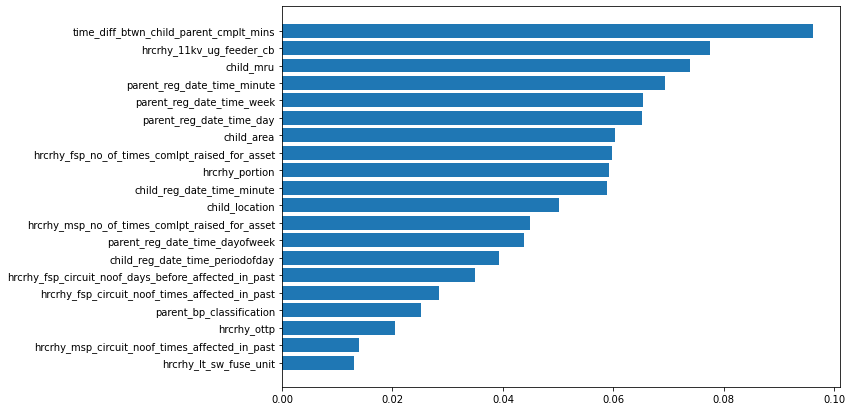

In [191]:
sorted_id = best_model.feature_importances_.argsort()
plt.figure(figsize=(10,7))
plt.barh(X_train.columns[sorted_id],best_model.feature_importances_[sorted_id])


In [219]:
# joblib.dump(best_model,base_location+"best_model.joblib")

# best_model = joblib.load(base_location+"best_model.joblib")

['kfs_private/best_model.joblib']

In [193]:
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.svm import SVC

# best_model = OneVsRestClassifier(SVC()).fit(X_train,y_train)

## Train Performance

In [194]:
label_list = y_train.unique().tolist()
label_list.sort()
label_list

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21]

In [195]:
best_model.classes_

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21])

Accuracy Score : 1.0
recall:  1.0
f1_scr:  1.0
precision_score:  1.0
Classification Report 
              precision    recall  f1-score   support

           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       578
           7       1.00      1.00      1.00       248
           8       1.00      1.00      1.00      6466
           9       1.00      1.00      1.00       318
          10       1.00      1.00      1.00        36
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00        72
          13       1.00      1.00      1.00      1756
          14       1.00      1.00      1.00      2036
          16       1.00      1.00      1.00       524
          17       1.00      1.00      1.00       194
          18       1.00      1.00      1.00      1880
          19       1.00      1.00      1.00       138
          20       1.00      1.00      1.00        98
          21       1.00      1.00      1.00

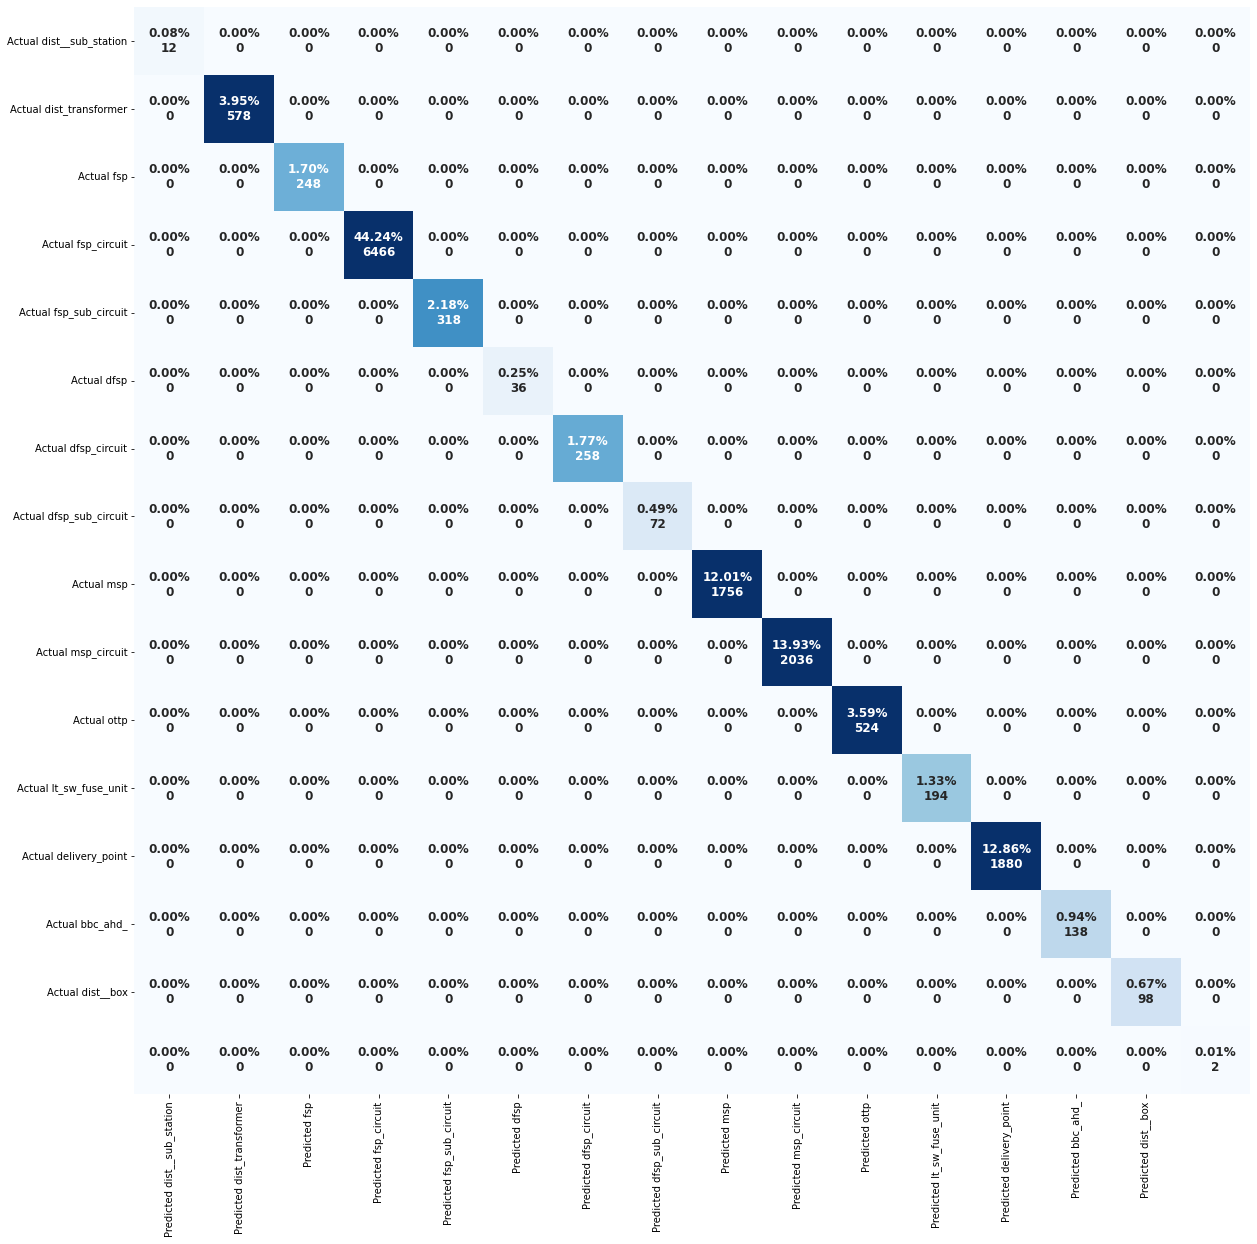

In [196]:
performance_matices(best_model, X_train, y_train, label_list)


## Validation Performance

In [197]:
label_list = y_val.unique().tolist()
label_list.sort()
label_list

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21]

Accuracy Score : 0.8578755567552976
recall:  0.8578755567552976
f1_scr:  0.853158189275539
precision_score:  0.870522820890319
Classification Report 
              precision    recall  f1-score   support

           5       1.00      0.67      0.80         6
           6       0.99      0.64      0.77       294
           7       1.00      0.51      0.67       124
           8       0.82      0.98      0.89      3316
           9       0.99      0.60      0.75       165
          10       1.00      0.61      0.76        18
          11       1.00      0.58      0.74       129
          12       1.00      0.56      0.71        36
          13       0.96      0.71      0.82       882
          14       0.86      0.81      0.83      1020
          16       0.87      0.79      0.82       262
          17       0.95      0.94      0.94        97
          18       0.84      0.88      0.86       941
          19       1.00      0.77      0.87        69
          20       1.00      0.73      

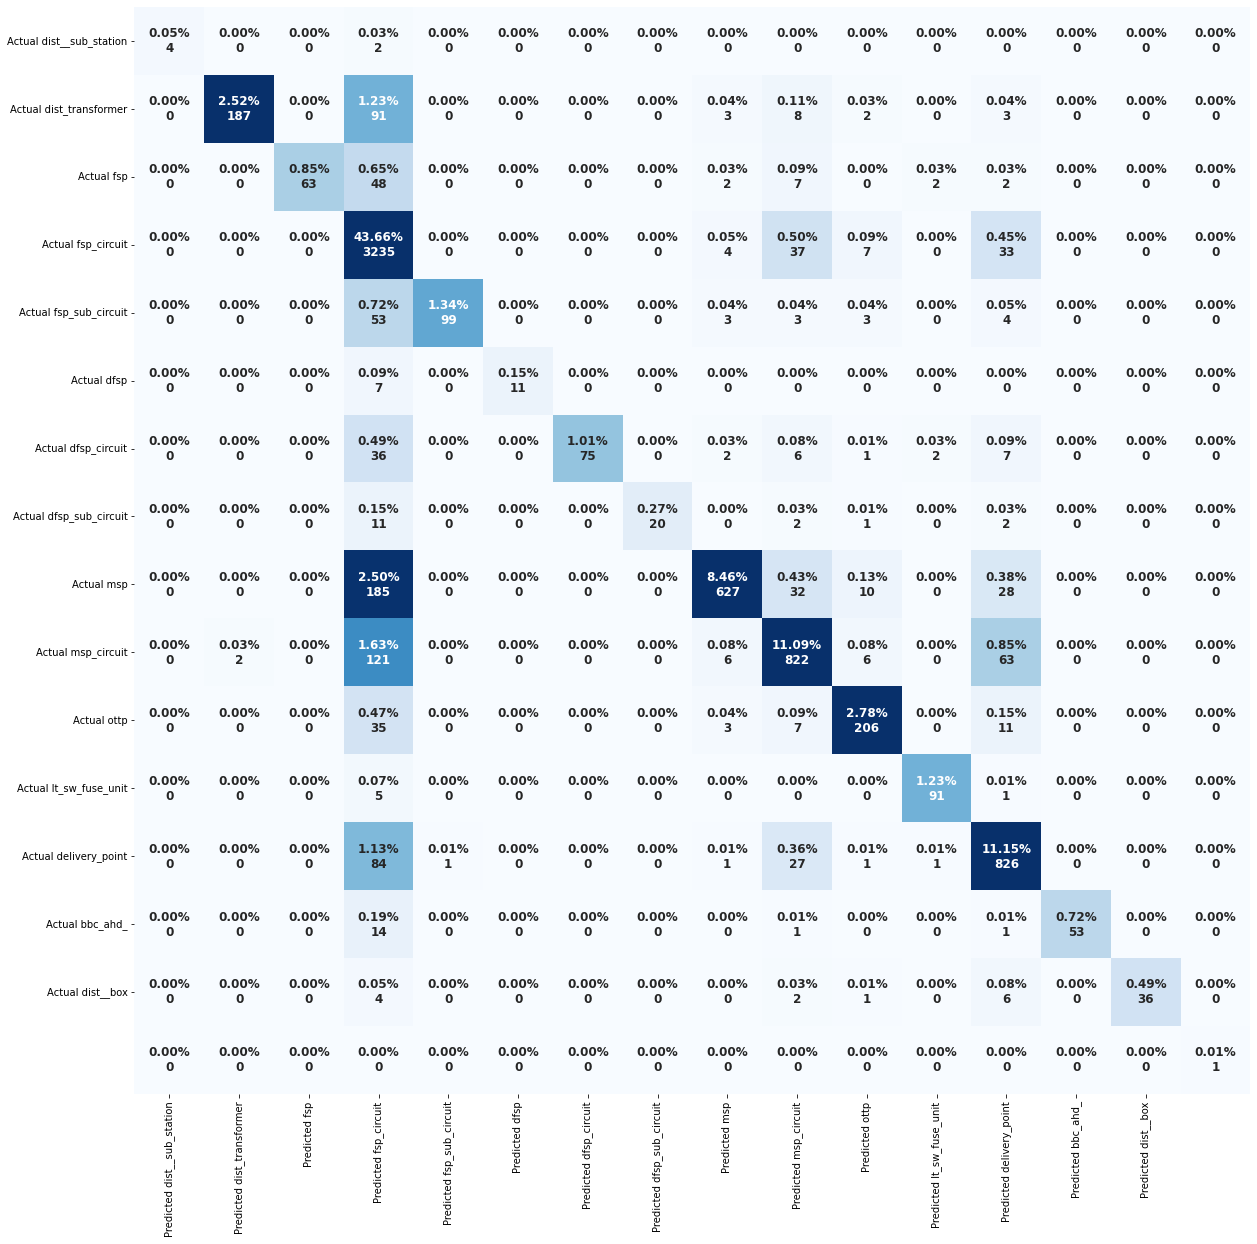

In [198]:
performance_matices(best_model, X_val, y_val, label_list)

## Test Performance

In [199]:
test_data.shape

(10335, 128)

In [200]:
test_data1 = test_data[test_data.groupby(['parent_complaint_number'])['child_partner_no'].transform('count')>cmplnt_fmly_crtcl_mass]

In [201]:
test_data1.shape

(5733, 128)

In [202]:
X_test = test_data1[X_val.columns]
y_test = test_data1[label]

In [203]:
label_list = y_test.unique().tolist()
label_list.sort()
label_list

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21]

Accuracy Score : 0.5102040816326531
recall:  0.5102040816326531
f1_scr:  0.42652608133520015
precision_score:  0.42250851000236117
Classification Report 
              precision    recall  f1-score   support

           5       0.00      0.00      0.00         3
           6       0.25      0.01      0.01       281
           7       0.00      0.00      0.00       128
           8       0.57      0.87      0.69      2782
           9       0.00      0.00      0.00       173
          10       0.00      0.00      0.00        23
          11       1.00      0.02      0.04        99
          12       0.00      0.00      0.00        21
          13       0.17      0.02      0.04       770
          14       0.34      0.29      0.31       631
          16       0.51      0.41      0.46       119
          17       0.62      0.39      0.48       102
          18       0.30      0.37      0.33       498
          19       0.94      0.28      0.43        54
          20       0.00      0.00  

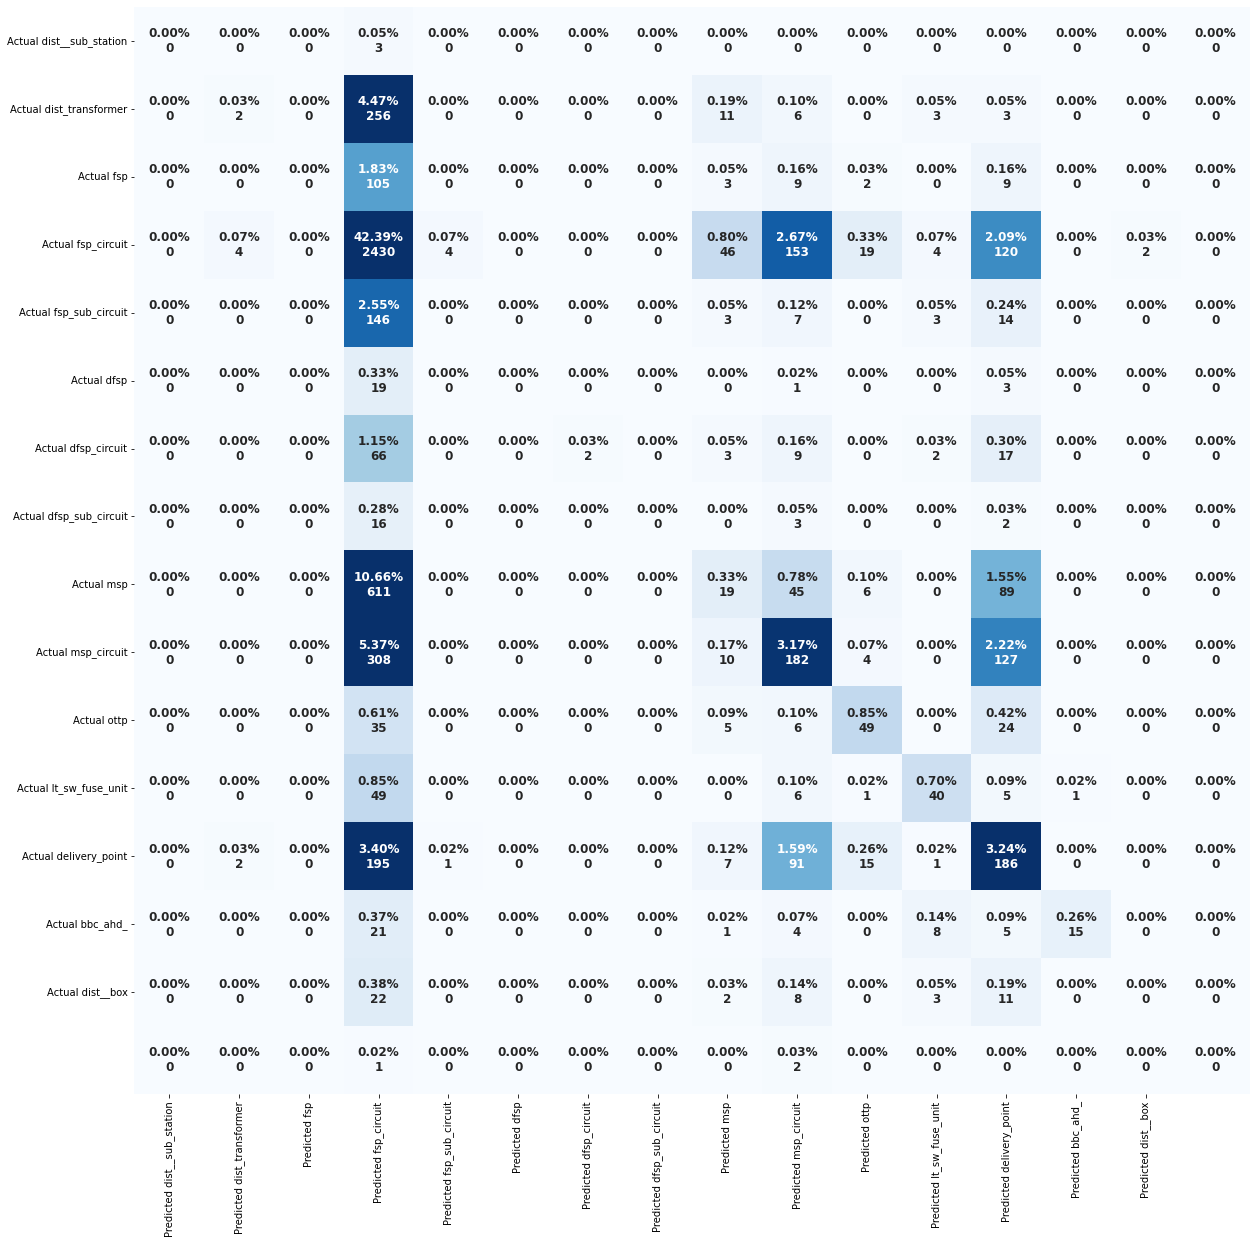

In [204]:
y_test_pred = best_model.predict(X_test)
performance_matices(best_model, X_test, y_test,label_list)

In [205]:
# import shap
# explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values[0],X_test)

In [206]:
label_list = [k for k,v in label_mapping_dist.items() if v in y_train.unique().tolist()]
label_list

['dist__sub_station',
 'dist_transformer',
 'fsp',
 'fsp_circuit',
 'fsp_sub_circuit',
 'dfsp',
 'dfsp_circuit',
 'dfsp_sub_circuit',
 'msp',
 'msp_circuit',
 'ottp',
 'lt_sw_fuse_unit',
 'delivery_point',
 'bbc_ahd_',
 'dist__box',
 'device_location']

In [209]:
import lime
import lime.lime_tabular
import dill
    
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_train.astype(int).values,mode = "classification",
                                                  training_labels=y_train,feature_names=top,class_names=label_list)

# with open(base_location+'lime_explainer.pkl', 'wb') as f:
#     dill.dump(explainer,f)
# with open(base_location+'lime_explainer.pkl', 'rb') as f:
#     explainer = dill.load(f)
    
exp = explainer.explain_instance(X_test.iloc[1],best_model.predict_proba, top_labels=1)

exp.show_in_notebook(show_table=True)

In [210]:
exp = explainer.explain_instance(X_test.loc[18089],best_model.predict_proba, top_labels=1)

exp.show_in_notebook(show_table=True)

In [211]:
test_result = parent_child_hrcrhy_df.loc[test_data1.index]
test_result['flg_actual'] = y_test
test_result['flg_predict'] = y_test_pred

In [212]:
test_result['diff_in_flg_actual_predict'] = abs(test_result['flg_actual']-test_result['flg_predict'])

In [213]:
test_result[test_result['flg_actual']!=8].shape

(2951, 291)

In [214]:
test_result[test_result['flg_actual']==8].shape

(2782, 291)

In [215]:
test_result[test_result['flg_predict']!=8].shape

(1450, 291)

In [216]:
test_result[test_result['flg_predict']==8].shape

(4283, 291)

In [217]:
temp = test_result[['parent_complaint_number','parent_business_partner',
              'child_partner_no','child_reg_date_time']+top+['hrcrhy_fsp_circuit','flg_actual','flg_predict','diff_in_flg_actual_predict']]

In [218]:
temp['diff_in_flg_actual_predict'].value_counts() / test_result.shape[0]

0     0.510204
5     0.133264
6     0.083203
2     0.061748
1     0.056166
10    0.054945
4     0.041514
3     0.017094
9     0.012210
8     0.011512
7     0.007152
11    0.005756
12    0.005058
13    0.000174
Name: diff_in_flg_actual_predict, dtype: float64

In [122]:
test_result[test_result['parent_complaint_number']==1006386286]['hrcrhy_dfsp_sub_circuit']

20003    not-connected
48446    not-connected
48867    not-connected
Name: hrcrhy_dfsp_sub_circuit, dtype: object

In [125]:
test_data1[test_data1['parent_complaint_number']==1006386286][X_val.columns]
# noof_days_before_affected_in_past
# no_of_times_comlpt_raised_for_asset
# noof_times_affected_in_past

child_location  \
20003              14   
48446              14   
48867              14   

       hrcrhy_11kv_ug_feeder_cb_no_of_times_comlpt_raised_for_asset  \
20003                                                 10              
48446                                                 11              
48867                                                 12              

       hrcrhy_ottp  hrcrhy_fsp_circuit_noof_times_affected_in_past  child_mru  \
20003            1                                            -1.0       -1.0   
48446            1                                             4.0     1468.0   
48867            1                                             4.0     4160.0   

       parent_reg_date_time_minute  time_diff_btwn_child_parent_cmplt_mins  \
20003                            6                                     2.0   
48446                            6                                    18.0   
48867                            6                                    23.0   

       child_description  child_area  child_reg_date_time_periodofday  \
20003                1.0       204.0                                4   
48446                1.0       204.0                                4   
48867                1.0       204.0                                4   

       hrcrhy_fsp_circuit_noof_days_before_affected_in_past  \
20003                                           0.000000      
48446                                           7.029167      
48867                                           7.029167      

       child_reg_date_time_day  parent_bp_classification  \
20003                        1                         4   
48446                        1                         4   
48867                        1                         4   

       child_reg_date_time_dayofweek  \
20003                              4   
48446                              4   
48867                              4   

       hrcrhy_msp_circuit_no_of_times_comlpt_raised_for_asset  \
20003                                                 -1        
48446                                                  1        
48867                                                  1        

       child_reg_date_time_month  \
20003                         10   
48446                         10   
48867                         10   

       hrcrhy_fsp_circuit_no_of_times_comlpt_raised_for_asset  \
20003                                                  1        
48446                                                  3        
48867                                                  4        

       hrcrhy_dist_transformer  child_reg_date_time_minute  hrcrhy_portion  
20003                     6455                           8              24  
48446                     6455                          24             120  
48867                     6455                          29             114

In [ ]:
temp[temp['flg_predict']<8]['parent_complaint_number'].unique()

In [ ]:
temp.groupby('parent_complaint_number')['diff_in_flg_actual_predict'].sum() == 5

In [ ]:
temp = pd.DataFrame(test_result[test_result['flg_predict']!=8].groupby('parent_complaint_number')['parent_business_partner'].count())
temp[temp['parent_business_partner']>=3]

### Sample data generation

In [ ]:
sample_complaints = parent_child_hrcrhy_df[(pd.to_datetime(parent_child_hrcrhy_df[
    'parent_reg_date'])>pd.to_datetime('01-07-2021')) & (parent_child_hrcrhy_df['flg']!='fsp_circuit')].sample(10)['parent_complaint_number'].tolist()

parent_sample = parent_comp_df[parent_comp_df['Complaint Number'].isin(sample_complaints)]
child_sample = child_comp_df[child_comp_df['Parent Complaint'].isin(sample_complaints)]

parent_sample = parent_sample.rename(columns={'Unnamed: 5':'MSP Circuit Description','Unnamed: 68':'FSP Circuit Description'})

In [ ]:
# parent_sample.to_csv(base_location+"parent_sample_data.csv",index=False,header=True)
# child_sample.to_csv(base_location+"child_sample_data.csv",index=False,header=True)

In [131]:
sample_complaints_heldout_data = test_data1['parent_complaint_number'].tolist()

parent_sample_heldout_data = parent_comp_df[parent_comp_df['Complaint Number'].isin(sample_complaints_heldout_data)]
child_sample_heldout_data = child_comp_df[child_comp_df['Parent Complaint'].isin(sample_complaints_heldout_data)]

parent_sample_heldout_data = parent_sample_heldout_data.rename(columns={'Unnamed: 5':'MSP Circuit Description','Unnamed: 68':'FSP Circuit Description'})

In [132]:
child_sample_heldout_data.shape

(5746, 143)

In [133]:
# parent_sample_heldout_data.to_csv(base_location+"parent_sample_heldout_data.csv",index=False,header=True)
# child_sample_heldout_data.to_csv(base_location+"child_sample_heldout_data.csv",index=False,header=True)

In [31]:
# parent_sample = pd.read_csv(base_location+"parent_sample_heldout_data.csv")
# child_sample = pd.read_csv(base_location+"child_sample_heldout_data.csv")

In [33]:
# hierarchy_df.columns

Index(['hrcrhy_zone', 'hrcrhy_portion', 'hrcrhy_business_partner',
       'hrcrhy_11kv_oh_feeder_cb', 'hrcrhy_11kv_ug_feeder_cb',
       'hrcrhy_22_kv_feeder', 'hrcrhy_22_kv_sub_feeder',
       'hrcrhy_ht_customer_ss', 'hrcrhy_dist__sub_station',
       'hrcrhy_dist_transformer', 'hrcrhy_fsp', 'hrcrhy_fsp_circuit',
       'hrcrhy_fsp_sub_circuit', 'hrcrhy_dfsp', 'hrcrhy_dfsp_circuit',
       'hrcrhy_dfsp_sub_circuit', 'hrcrhy_msp', 'hrcrhy_msp_circuit',
       'hrcrhy_otdp', 'hrcrhy_ottp', 'hrcrhy_lt_sw_fuse_unit',
       'hrcrhy_delivery_point', 'hrcrhy_bbc_ahd_', 'hrcrhy_dist__box',
       'hrcrhy_device_location', 'hrcrhy_count'],
      dtype='object')

In [38]:
# child_sample.merge(hierarchy_df,left_on='Partner No',right_on='hrcrhy_business_partner')['hrcrhy_dfsp_sub_circuit'].value_counts()

In [ ]:
child_sample.info()

In [ ]:
parent_sample.columns = rename_columns(parent_sample,prefix="parent_")
child_sample.columns = rename_columns(child_sample,prefix="child_")

In [ ]:
feature_meta_dict = joblib.load(base_location+"feature_meta_dict.joblib")

In [ ]:
import copy
feature_meta_dict_temp = copy.deepcopy(feature_meta_dict)

In [ ]:
parent_child_sample_df = parent_sample.merge(child_sample, left_on=['parent_complaint_number'],right_on=['child_parent_complaint'],how='inner')
parent_child_hrcrhy_sample_df = parent_child_sample_df.merge(hierarchy_df,left_on='child_partner_no',right_on='hrcrhy_business_partner',how='inner')

In [ ]:
parent_child_hrcrhy_sample_df.shape

In [ ]:
parent_child_hrcrhy_sample_df['parent_reg__time'] = fill_parent_reg__time(parent_child_hrcrhy_sample_df)
parent_child_hrcrhy_sample_df['parent_rate_category'] = fill_parent_rate_category(parent_child_hrcrhy_sample_df)

parent_child_hrcrhy_sample_df['parent_area'] = fill_parent_area(parent_child_hrcrhy_sample_df[['parent_area']])
parent_child_hrcrhy_sample_df['parent_mru'] = fill_parent_mru(parent_child_hrcrhy_sample_df[['parent_mru']])

parent_child_hrcrhy_sample_df['parent_reg_date_time'] = format_parent_reg_date(parent_child_hrcrhy_sample_df)
parent_child_hrcrhy_sample_df['child_reg_date_time'] = format_child_reg_date(parent_child_hrcrhy_sample_df)

In [ ]:
parent_child_hrcrhy_sample_df.sort_values('child_reg_date_time',inplace=True)

In [ ]:
def no_of_times_comlpt_for_bulk_customer(x,col,col_gen):
    
    if x in feature_meta_dict_temp[col+col_gen]:
        val = feature_meta_dict_temp[col+col_gen][x]
        feature_meta_dict_temp[col+col_gen][x] = val+1
    else:
        val = 0
        feature_meta_dict_temp[col+col_gen][x] = val+1
        
    return val
    

In [ ]:
col_gen = '_no_of_times_comlpt_raised_for_asset'
for col_gen in col_gen_list:
    for col in hierarchy_cols:
        parent_child_hrcrhy_sample_df[col+col_gen] = parent_child_hrcrhy_sample_df.apply(
            lambda x: no_of_times_comlpt_for_bulk_customer(x[col],col,col_gen),axis=1)

In [ ]:
def no_of_times_comlpt_for_bulk_customer(x,col_gen):
    
    for col in hierarchy_cols:
        if x in feature_meta_dict_temp[col+col_gen]:
            val = feature_meta_dict_temp[col+col_gen][x]
            feature_meta_dict_temp[col+col_gen][x] = val+1
        else:
            val = 0
            feature_meta_dict_temp[col+col_gen][x] = val+1
        x[col_col_gen] = val
    return x
    

In [ ]:
parent_child_hrcrhy_sample_df = parent_child_hrcrhy_sample_df.apply(
    lambda x: no_of_times_comlpt_for_bulk_customer(x,"_no_of_times_comlpt_raised_for_asset"),axis=1)

In [ ]:
feature_meta_dict_temp['hrcrhy_msp'+'_no_of_times_comlpt_raised_for_asset']['A-D-MSPC-0003-106']

In [ ]:
feature_meta_dict['hrcrhy_msp'+'_no_of_times_comlpt_raised_for_asset']['A-D-MSPC-0003-106']

In [ ]:
parent_child_hrcrhy_sample_df['hrcrhy_msp'].unique()